Tutorial 4: 3D motion estimation
Script for Point Cloud Alignment
Practical Course: Learning For Self-Driving Cars and Intelligent Systems
Summer Semester 2021
Technical University of Munich
Tutor: Qadeer Khan
https://vision.in.tum.de/teaching/ss2021/intellisys_ss2021

In [1]:
import open3d as o3d
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import torch
from skimage import io
import os
import json
import pdb
import time
import copy
import glob
import cv2
print(o3d.__version__)
FOLDER = "/storage/group/intellisys/datasets/carla/episode_000"

0.10.0.0


In [2]:
def read_rgb(rgb_file):
    rgb = io.imread(rgb_file)
    plt.imshow(rgb)
    plt.title(rgb_file)
    plt.show()
    return rgb

def read_depth(depth_file):
    depth = io.imread(depth_file)
    # Reference: https://carla.readthedocs.io/en/stable/cameras_and_sensors/#camera-depth-map
    depth = depth[:, :, 0] * 1.0 + depth[:, :, 1] * 256.0 + depth[:, :, 2] * (256.0 * 256)
    depth = depth * (1/ (256 * 256 * 256 - 1))
    return depth

def point_cloud_to_image(points,color ,K,width=512, height=512, transformation = None):
    points = np.transpose(points, (1,0))
    if transformation is not None:
        tmp = np.ones((4,points.shape[1]))
        tmp[:3,:] = points
        tmp = transformation @ tmp
    else:
        tmp = points
        
    tmp = K @ tmp
    tmp1 = tmp/tmp[2,:]
    # TODO:
    # Note that multiple points might be mapped to the same pixel
    # The one with the lowest depth value should be assigned to that pixel
    # However, note this has not been implemented here
    # This needs to be implemented
    u_cord = np.clip(np.round(tmp1[0,:]),0,width - 1).astype(np.int)
    v_cord = np.clip(np.round(tmp1[1,:]),0,height - 1).astype(np.int)
    imtmp = np.zeros((height,width,3)).astype(np.uint8)
    imtmp[v_cord, u_cord,:]= (color).astype(np.uint8)

    plt.imshow(imtmp)
    plt.show()
    


def depth_to_local_point_cloud(image, color=None, k = np.eye(3),max_depth=1.1):
    """
    Convert an image containing CARLA encoded depth-map to a 2D array containing
    the 3D position (relative to the camera) of each pixel and its corresponding
    RGB color of an array.
    "max_depth" is used to omit the p+oints that are far enough.
    Reference: 
    https://github.com/carla-simulator/driving-benchmarks/blob/master/version084/carla/image_converter.py
    """
    far = 1000.0  # max depth in meters.
    normalized_depth = image# depth_to_array(image)
    height, width = image.shape


    # 2d pixel coordinates
    pixel_length = width * height
    u_coord = repmat(np.r_[width-1:-1:-1],
                     height, 1).reshape(pixel_length)
    v_coord = repmat(np.c_[height-1:-1:-1],
                     1, width).reshape(pixel_length)
    if color is not None:
        color = color.reshape(pixel_length, 3)
    normalized_depth = np.reshape(normalized_depth, pixel_length)

    # Search for pixels where the depth is greater than max_depth to
    # delete them
    max_depth_indexes = np.where(normalized_depth > max_depth)
    normalized_depth = np.delete(normalized_depth, max_depth_indexes)
    u_coord = np.delete(u_coord, max_depth_indexes)
    v_coord = np.delete(v_coord, max_depth_indexes)
    if color is not None:
        color = np.delete(color, max_depth_indexes, axis=0)

    # pd2 = [u,v,1]
    p2d = np.array([u_coord, v_coord, np.ones_like(u_coord)])

    # P = [X,Y,Z]
    p3d = np.dot(np.linalg.inv(k), p2d)
    p3d *= normalized_depth * far
    p3d = np.transpose(p3d, (1,0))
    return p3d, color / 255.0

0000000000


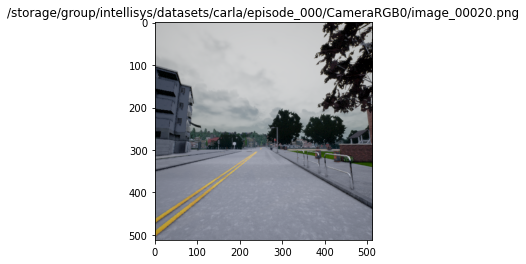

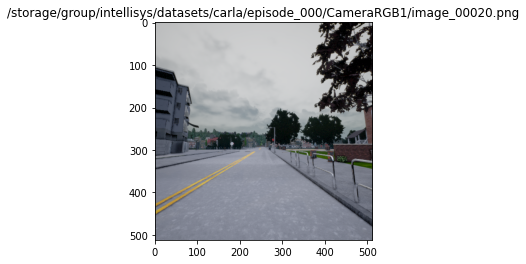

Point Coud 1, projected back to image 1


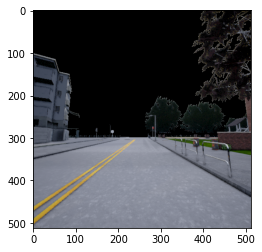

Point Coud 1, projected back to image 2


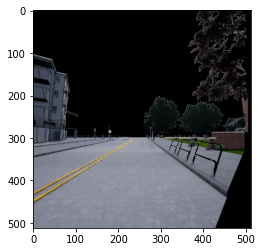

Point Coud 2, projected back to image 2


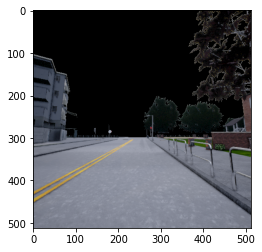

1111111111


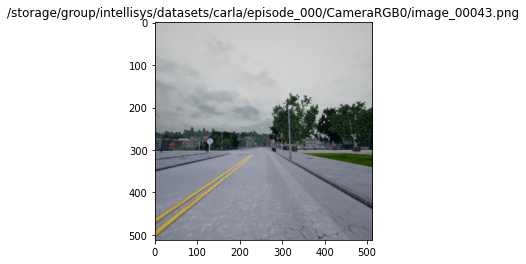

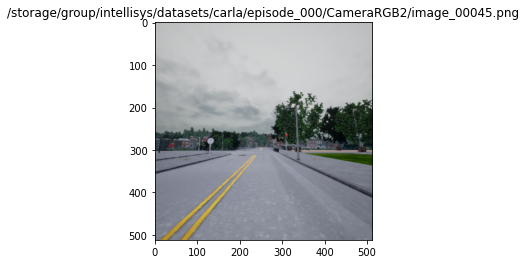

Point Coud 1, projected back to image 1


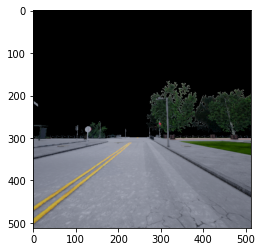

Point Coud 1, projected back to image 2


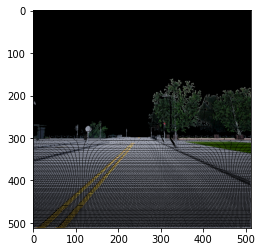

Point Coud 2, projected back to image 2


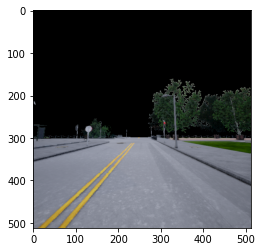

2222222222


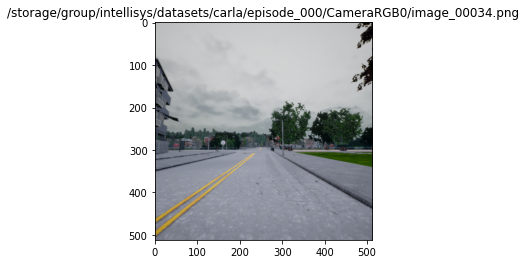

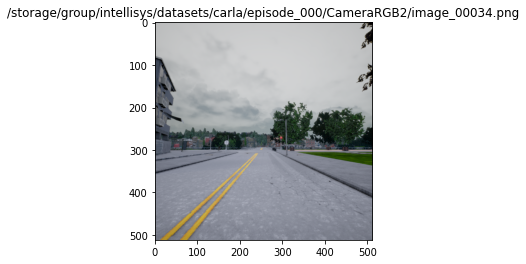

Point Coud 1, projected back to image 1


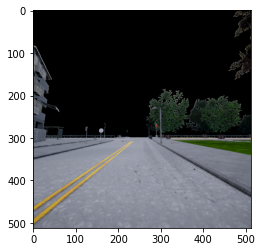

Point Coud 1, projected back to image 2


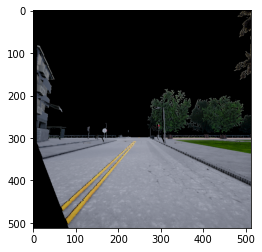

Point Coud 2, projected back to image 2


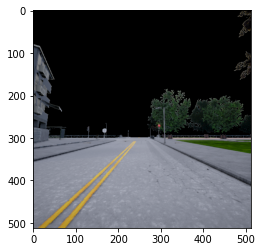

3333333333


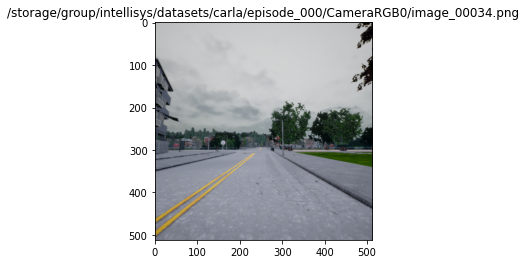

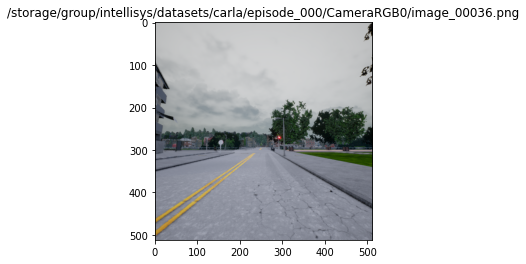

Point Coud 1, projected back to image 1


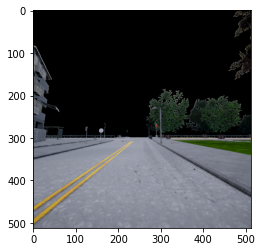

Point Coud 1, projected back to image 2


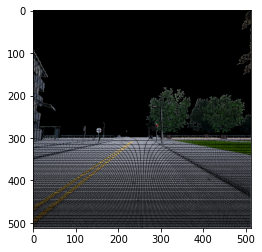

Point Coud 2, projected back to image 2


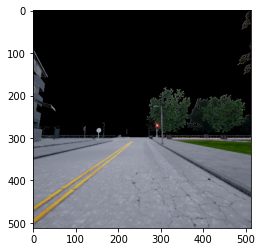

4444444444


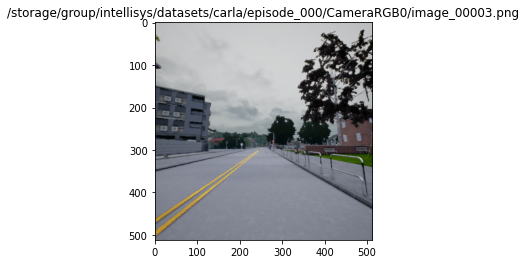

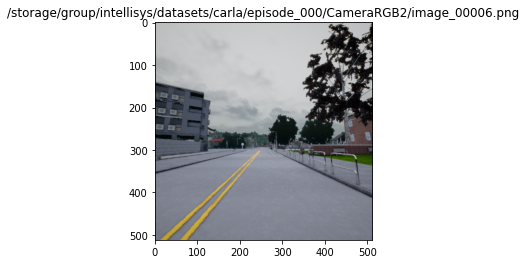

Point Coud 1, projected back to image 1


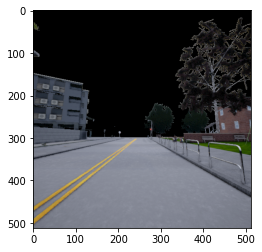

Point Coud 1, projected back to image 2


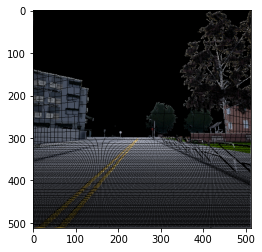

Point Coud 2, projected back to image 2


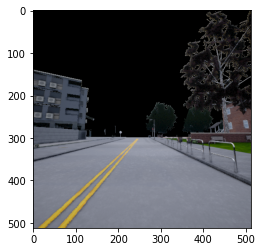

5555555555


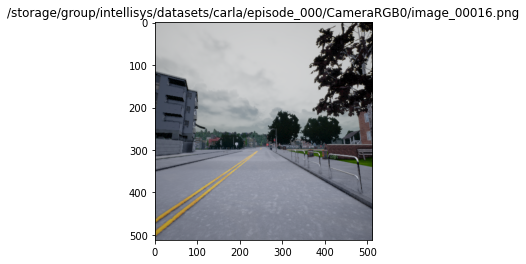

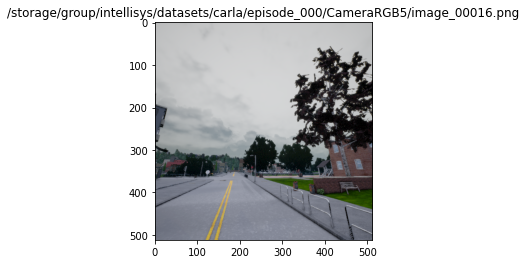

Point Coud 1, projected back to image 1


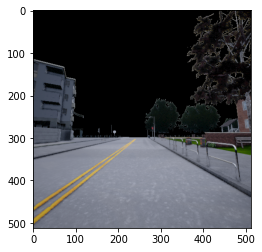

Point Coud 1, projected back to image 2


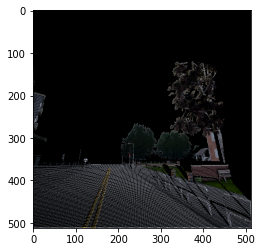

Point Coud 2, projected back to image 2


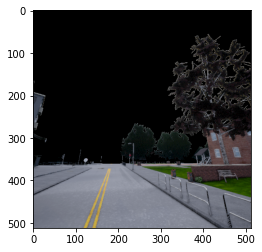

6666666666


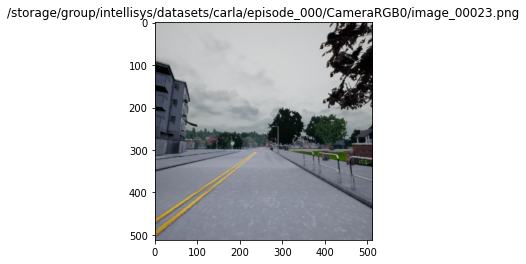

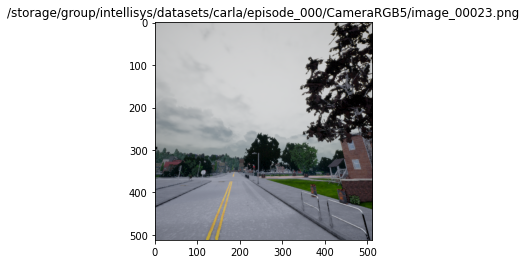

Point Coud 1, projected back to image 1


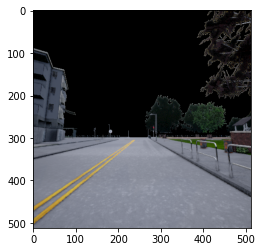

Point Coud 1, projected back to image 2


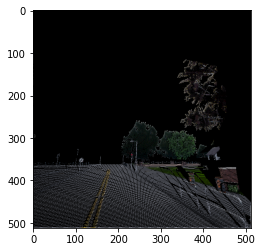

Point Coud 2, projected back to image 2


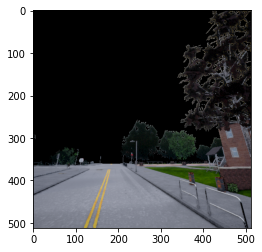

7777777777


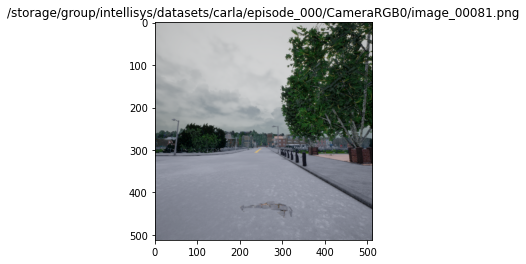

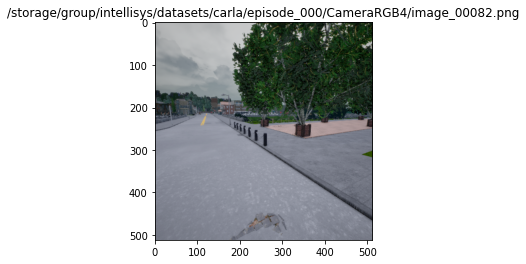

Point Coud 1, projected back to image 1


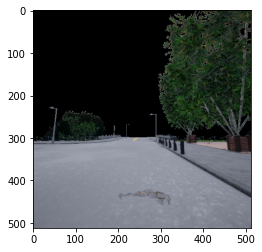

Point Coud 1, projected back to image 2


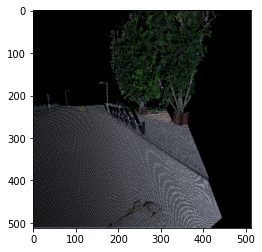

Point Coud 2, projected back to image 2


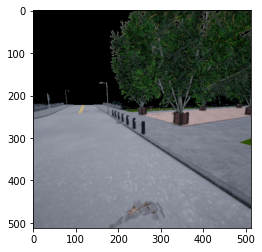

8888888888


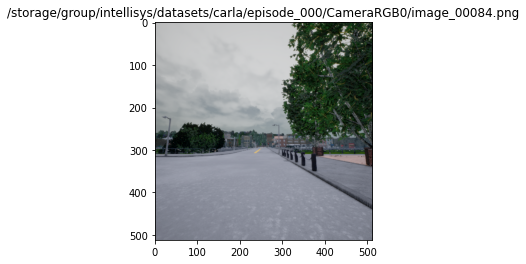

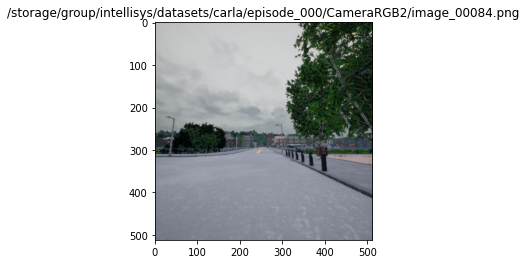

Point Coud 1, projected back to image 1


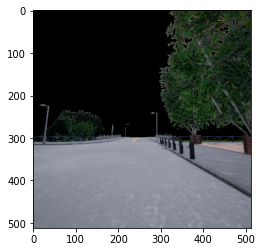

Point Coud 1, projected back to image 2


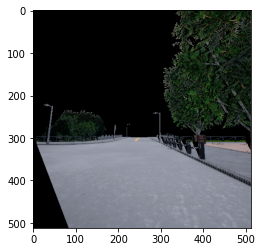

Point Coud 2, projected back to image 2


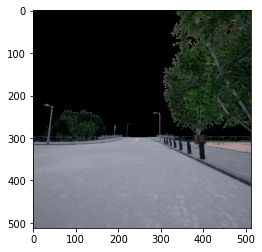

9999999999


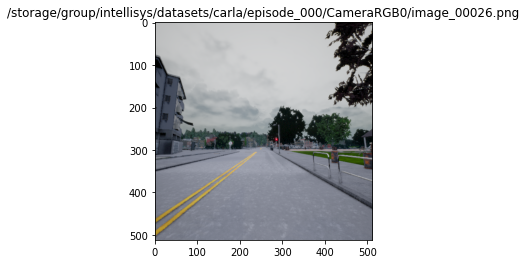

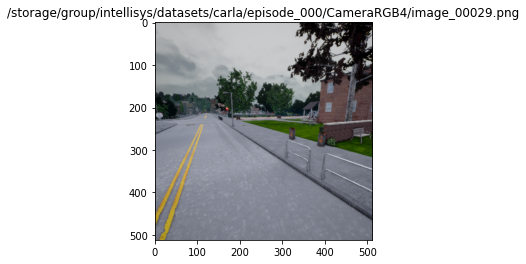

Point Coud 1, projected back to image 1


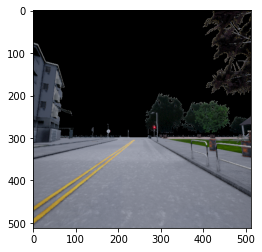

Point Coud 1, projected back to image 2


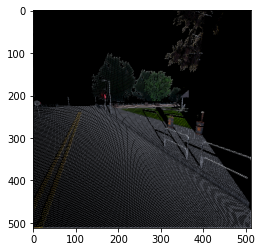

Point Coud 2, projected back to image 2


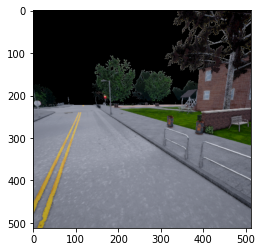

In [3]:
%matplotlib inline
for i in range(10):
    print(str(i)*10)
    
    cam1 = 0
    cam2 = np.random.randint(0,6)
    frame1 = np.random.randint(1,94) 
    frame2 = frame1 + np.random.randint(0,4)

    frame1 = format(frame1, '05d')
    frame2 = format(frame2, '05d')


    rgb_file1   = os.path.join(FOLDER, "CameraRGB{}/image_{}.png".format(cam1, frame1))
    rgb_file2   = os.path.join(FOLDER, "CameraRGB{}/image_{}.png".format(cam2, frame2))
    depth_file1 = os.path.join(FOLDER, "CameraDepth{}/image_{}.png".format(cam1, frame1))
    depth_file2 = os.path.join(FOLDER, "CameraDepth{}/image_{}.png".format(cam2, frame2))
    intrinsics_file = os.path.join(FOLDER,"camera_intrinsic.json")
    extrinsics_file = os.path.join(FOLDER,"transforms.json")

    with open(intrinsics_file) as f:
        K = json.load(f)
    K = np.array(K)

    with open(extrinsics_file) as f:
        extrinsics = json.load(f)

    pose1 = np.array(extrinsics['image_{}'.format(frame1)][cam1])
    pose2 = np.array(extrinsics['image_{}'.format(frame2)][cam2])
    rel_pose12 = np.linalg.inv(pose2) @ (pose1)


    rgb1 = read_rgb(rgb_file1)
    rgb2 = read_rgb(rgb_file2)
    # Note that the depth values below are normalized to between 0 and 1. 
    depth1 = read_depth(depth_file1)
    depth2 = read_depth(depth_file2)

    
    # Moving Point cloud from Image1 to Frame of reference of Image2
    height, width = depth1.shape

    
    pixel_length = width * height
    u_coord = repmat(np.r_[width-1:-1:-1],
                         height, 1).reshape(pixel_length)
    v_coord = repmat(np.c_[height-1:-1:-1],
                         1, width).reshape(pixel_length)

    depths = depth1[v_coord, u_coord] * 1000
    color1 = rgb1[v_coord, u_coord]
    
    # Remove points greater than 50 meters   
    max_depth_indexes = np.where(depths > 50)
    depths = np.delete(depths, max_depth_indexes)
    color1 = np.delete(color1, max_depth_indexes, axis = 0)
    u_coord = np.delete(u_coord, max_depth_indexes)
    v_coord = np.delete(v_coord, max_depth_indexes)
    
    
    homogenous = np.vstack((u_coord, v_coord, np.ones_like(u_coord)))
    p3d = np.linalg.inv(K) @ (homogenous*depths)
    pc1InRef2 = (rel_pose12 @ np.vstack((p3d, np.ones_like(u_coord))))[:3,:]
    
    print("Point Coud 1, projected back to image 1")
    point_cloud_to_image(p3d.T,color1 ,K,width, height,transformation = None)   
    
    print("Point Coud 1, projected back to image 2")
    point_cloud_to_image(pc1InRef2.T,color1 ,K,width,height,transformation = None)

    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(pc1InRef2.T)
    
    # Saving point cloud 1 WITHOUT rgb color    
    pcd1.paint_uniform_color([1, 0.706, 0])
    o3d.io.write_point_cloud("pc_{}_1.ply".format(i), pcd1)
    
    # Saving point cloud 1 with color 
    pcd1.colors = o3d.utility.Vector3dVector(color1/255.0)
    o3d.io.write_point_cloud("pc_color_{}_1.ply".format(i), pcd1)



    # Point Cloud of Image2
    pixel_length = width * height

    u_coord = repmat(np.r_[width-1:-1:-1],
                         height, 1).reshape(pixel_length)
    v_coord = repmat(np.c_[height-1:-1:-1],
                         1, width).reshape(pixel_length)

    depths = depth2[v_coord, u_coord] * 1000
    color2 = rgb2[v_coord, u_coord]
   
    # Remove points greater than 50 meters  
    max_depth_indexes = np.where(depths > 50)
    depths = np.delete(depths, max_depth_indexes)
    color2 = np.delete(color2, max_depth_indexes, axis = 0)
    u_coord = np.delete(u_coord, max_depth_indexes)
    v_coord = np.delete(v_coord, max_depth_indexes)


    homogenous = np.vstack((u_coord, v_coord, np.ones_like(u_coord)))
    p3d = np.linalg.inv(K) @ (homogenous*depths)
    
    print("Point Coud 2, projected back to image 2")
    point_cloud_to_image(p3d.T,color2 ,K,width,height,transformation = None) 

    pcd2 = o3d.geometry.PointCloud()
    pcd2.points = o3d.utility.Vector3dVector(p3d.T)
    
    # Saving point cloud 2 WITHOUT rgb color  
    pcd2.paint_uniform_color([0, 0.651, 0.929])
    o3d.io.write_point_cloud("pc_{}_2.ply".format(i), pcd2)
    
    # Saving point cloud 2 with color 
    pcd2.colors = o3d.utility.Vector3dVector(color2/255.0)
    o3d.io.write_point_cloud("pc_color_{}_2.ply".format(i), pcd2)